In [5]:
from tim_utils import *

import complextorch as cT
from complextorch.nn.modules.conv import *
from complextorch.nn.modules.attention.eca import *
from complextorch.nn.modules.layernorm import CVLayerNorm
from complextorch.nn.modules.batchnorm import CVBatchNorm2d
from complextorch.nn.modules.dropout import CVDropout
from complextorch.nn import functional as cF

from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image, ImageReadMode
from torchvision.utils import make_grid

from CVNAFNet import *

import googlemaps
from PIL import Image
import requests
from io import BytesIO
import pyperclip

from sarpy.visualization.remap import Density, High_Contrast, Linear
from sarpy.io.complex.sicd import SICDReader


from datasets import SICDDataset
#from data_transforms import ComplexNormPolar

device = tim.torch_device()
device = 'cpu'
remap_function = Density()
def remap(compTensor):
    out = T.empty(compTensor.size())[0:0]
    for n in range(compTensor.size(0)):
        mapped = remap_function(compTensor[n].detach().cpu().numpy())
        out = T.cat((out, T.Tensor(mapped)[None]))
    return out


In [6]:
ones = T.ones(5, dtype=T.float16)
T.complex(ones, ones)

tensor([1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j], dtype=torch.complex32)

In [7]:
batch_size =2
shuffle = True
num_workers =0
image_size = 500

mmmn = cT.nn.MagMinMaxNorm()

dataset = SICDDataset("files/capella", file_hw=image_size, transform=mmmn, sample_rate=2)
sicdDataloader = DataLoader(dataset,
                    batch_size=batch_size, shuffle=shuffle,num_workers=num_workers)
sicd = next(iter(sicdDataloader))
sicd.shape, sicd.type()

(torch.Size([2, 1, 500, 500]), 'torch.ComplexFloatTensor')

In [12]:
sicd

tensor([[[[ 0.1568+0.1254j, -0.0157+0.0157j,  0.0157-0.0470j,  ...,
           -0.0314+0.1725j, -0.1254-0.1725j,  0.0627+0.1254j],
          [-0.1725-0.2979j, -0.4077+0.0000j, -0.1568+0.1411j,  ...,
           -0.3920+0.1568j, -0.0941+0.0470j,  0.2509-0.1882j],
          [-0.0157+0.2666j, -0.0314-0.1254j,  0.1411-0.0941j,  ...,
           -0.3450+0.0627j, -0.1568-0.0470j, -0.3450+0.2509j],
          ...,
          [-0.4547+0.6272j, -0.3920-0.0157j, -0.0470-0.1254j,  ...,
           -0.1254-0.1254j,  0.2979-0.2979j, -0.0784+0.1568j],
          [ 0.1725-0.3136j, -0.3450+0.2822j, -0.3763+0.3136j,  ...,
           -0.0784+0.1725j, -0.4547+0.2352j,  0.0314-0.1411j],
          [-0.1568-0.0470j,  0.2666-0.0627j,  0.0157-0.0941j,  ...,
            0.0157-0.3606j, -0.0157+0.4234j,  0.1411-0.0784j]]],


        [[[ 0.0089+0.0139j,  0.0228+0.0266j, -0.0178-0.0101j,  ...,
           -0.0038+0.0279j, -0.0254+0.0254j, -0.0228-0.0406j],
          [ 0.0178+0.0063j,  0.0190+0.0254j, -0.0330+0.0203j,  .

In [8]:
def fft_downsample(inp, downsample_rate=2, maintain_size=False, random_state=None):
    isicd = T.fft.ifft2(inp)
    h,w = isicd.shape[2:]
    h_,w_ = h//downsample_rate, w//downsample_rate
    np.random.seed(random_state)
    start_h = np.random.choice(1+h-h_)
    start_w = np.random.choice(1+w-w_)
    if maintain_size:
        mask = T.zeros_like(inp)
        mask[..., start_h:start_h+h_, start_w:start_w+w_] = 1
        return T.fft.fft2(isicd*mask)
    else:
        return T.fft.fft2(isicd[..., start_h:start_h+h_, start_w:start_w+w_])


In [9]:
def image_center_crop(input_image, output_size):
    if isinstance(output_size, int):
        output_size = (output_size, output_size)
    else:
        output_size = output_size[-2:]
    h,w = input_image.shape[-2:]
    h_, w_ = int(h-output_size[0]), int(w-output_size[1])
    return input_image[...,h_:output_size[0]+h_, w_:output_size[1]+w_]

In [10]:
enc_lay= [2,2,2]
dec_lay= [2,2,2]
gen_middle = 3
scale_factor = 2
output_dim =16

SRNet = CVNAFNet(middle_blk_num=gen_middle,enc_blk_nums=enc_lay, dec_blk_nums=dec_lay, scale=scale_factor).to(device)
DNet = CVNAFEnc(enc_blk_nums=enc_lay, output_hw=output_dim).to(device)
#dsNet = CVDownSample(image_size, downsample_rate=scale_factor)
#down_sicd = dsNet(sicd)
#sr_sicd = SRNet(down_sicd.to(device))
#sr_sicd.size(),image_center_crop(sr_sicd, sicd.size()).shape
tim.torch_parameter_count(SRNet)
tim.torch_parameter_count(DNet)

The network has 1066522 trainable parameters
The network has 488302 trainable parameters


In [11]:
import itertools
lr = 0.0005
b1 = 0.5
b2 = 0.999

optimizerSR = T.optim.Adam(SRNet.parameters(), lr=lr, betas=(b1, b2))
optimizerD = T.optim.Adam(DNet.parameters(), lr=lr, betas=(b1,b2))
n_epochs = 100
decay_epoch = 20

# lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

# lr_scheduler_G = T.optim.lr_scheduler.LambdaLR(optimizerSR, lr_lambda=lambda_func)

class ComplexTorchLoss():
    def __init__(self, loss_fn) -> None:
        self.loss_fn = loss_fn
    def to(self, device):
        self.loss_fn = self.loss_fn.to(device)
        return self
    def __call__(self, pred, target,*args, **kwds):
        real_loss = self.loss_fn(pred.real, target.real)
        imag_loss = self.loss_fn(pred.imag, target.imag)
        return T.complex(real_loss, imag_loss).type(T.complex64)


class MaxSquaredError():
    def __init__(self) -> None:
        pass
    def to(self, device):
        self.device =  device
        return self
    def __call__(self, pred, target):
        return T.max(T.pow(pred-target, 2)).to(self.device)

# gan_loss = cT.nn.CVFourthPowError().to(device)
#mse = ComplexTorchLoss(T.nn.MSELoss()).to(device)
mse = ComplexTorchLoss(MaxSquaredError()).to(device)
l1 = ComplexTorchLoss(T.nn.L1Loss(reduction='sum')).to(device)

ssim = cT.nn.SplitSSIM()
#l1loss = cT.nn.SplitL1()
#mse = cT.nn.SplitMSE()

In [9]:
n_epochs = 10
complex_loss = tim.bool[0]
for epoch in range(n_epochs):
    for i, sicd in enumerate(sicdDataloader):
        '''way to control loop exit and forces models to save gracefully'''
        with open("epochs/model_weights/stop.txt", 'r') as f:
            if f.read().lower().__contains__("true"):
                epoch = n_epochs
                print("Exited by file control stop.txt")
                break

        sicd = sicd.to(device)

        out_shape = [sicd.size(0), 1, output_dim, output_dim]
        ones = T.ones(out_shape).to(device)

        valid = T.complex(ones, ones).to(device)
        fake = T.complex(-1*ones, -1*ones).to(device)

        optimizerSR.zero_grad()
        optimizerD.zero_grad()
        #create low res image by downsampling
        lrSicd = fft_downsample(sicd, downsample_rate=scale_factor, maintain_size=True)
        
        '''Train Generator'''
        srsicd = SRNet(lrSicd)
        srSicd = image_center_crop(srsicd, sicd.size())
        
        if srSicd.isnan().any().item():
            print(i)
            break
        ganLoss = l1(DNet(srSicd), valid)
        mseLoss = l1(sicd, srSicd)
        g_loss = mseLoss+ganLoss
        if complex_loss:
            g_loss.backward(T.ones_like(g_loss))
        else:
            g_loss = g_loss.abs()
            g_loss.backward()
        
        # mseloss:{mseloss.item()}")# ssim_loss:{ssim_loss.item()}")
        optimizerSR.step()

        '''Train Discriminator'''
        validLoss = l1(DNet(sicd), valid)
        lrLoss = l1(DNet(lrSicd.detach()), fake)
        fakeLoss = l1(DNet(srSicd.detach()), fake)
        d_loss = validLoss + fakeLoss + lrLoss
        if complex_loss:
            d_loss.backward(T.ones_like(d_loss))
        else:
            d_loss = d_loss.abs()
            d_loss.backward()
        print(f"{i} G_loss:{g_loss.item()} D_loss:{d_loss.item()}")
        optimizerD.step()
        
        '''Plot results on a sampling basis'''
        
        if tim.bool[0] or (i%1==0):
            n_rows = np.min([sicd.size(0), 5])
            plt.figure(figsize=(5*3, 5*n_rows))
            plt.subplot(1,3,1)
            plt.imshow(make_grid(remap(sicd[:n_rows]).type(T.int), nrow=1)[0], cmap='hot') 
            plt.axis('off')
            plt.title("Original SICD")

            plt.subplot(1,3,2)
            plt.imshow(make_grid(remap(lrSicd[:n_rows]).type(T.int), nrow=1)[0], cmap='hot') 
            plt.axis('off')
            plt.title("Sub-Sampled SICD")

            plt.subplot(1,3,3)
            plt.imshow(make_grid(remap(srSicd[:n_rows]).type(T.int), nrow=1)[0], cmap='hot') 
            plt.axis('off')
            plt.title("SR SICD")

            plt.suptitle(f"SAR for Epoch {epoch} Iteration {i}")
            plt.tight_layout()
            plt.savefig(f"epochs/SR_epoch{epoch}_{i}.png")
            plt.close()
    T.save(SRNet.state_dict(), f"epochs/model_weights/srNet_epoch{epoch}.pt")
    T.save(DNet.state_dict(), f"epochs/model_weights/dNet_epoch{epoch}.pt")


0 G_loss:15211.6611328125 D_loss:2584.111083984375
1 G_loss:22880.181640625 D_loss:2076.880126953125
2 G_loss:18254.060546875 D_loss:2094.85986328125
3 G_loss:72423.1484375 D_loss:2116.59765625
4 G_loss:191343.8125 D_loss:2129.9306640625
5 G_loss:65932.71875 D_loss:2130.85693359375
6 G_loss:118516.5546875 D_loss:2133.343505859375
7 G_loss:77514.765625 D_loss:2135.32666015625
8 G_loss:6850.505859375 D_loss:2136.88427734375
9 G_loss:99448.5 D_loss:2136.431396484375
10 G_loss:96276.390625 D_loss:2136.013916015625
11 G_loss:119387.1796875 D_loss:2141.15380859375
12 G_loss:107422.671875 D_loss:2139.04833984375
13 G_loss:93361.0625 D_loss:2145.632080078125
14 G_loss:37088.82421875 D_loss:2158.959716796875
15 G_loss:37293.671875 D_loss:2156.00830078125
16 G_loss:36092.796875 D_loss:2156.112548828125
17 G_loss:23487.498046875 D_loss:2169.43505859375
18 G_loss:62793.44140625 D_loss:2166.8427734375
19 G_loss:50548.890625 D_loss:2171.095947265625
20 G_loss:34028.41015625 D_loss:2181.461181640625


In [ ]:
srSicd

In [ ]:
srSicd.isnan().all(), srSicd.isnan().any().item()

In [12]:
if tim.bool[1]:
    batch_size =1
    shuffle = True
    num_workers =0
    image_size = 5000
    mmmn = cT.nn.MagMinMaxNorm()
    #cnp = ComplexNormPolar()

    dataset = SICDDataset("files/capella", chip=True, file_hw=image_size, transform=mmmn, sample_rate=5)
    sicdDataloader = DataLoader(dataset,
                        batch_size=batch_size, shuffle=shuffle,num_workers=num_workers)
    sicd = next(iter(sicdDataloader))

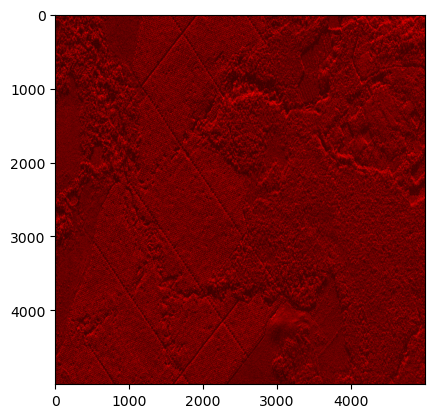

In [13]:
tmp = remap(sicd)
plt.imshow(tmp[0][0].type(T.int), cmap='hot')

In [ ]:
lrSicd = fft_downsample(sicd,4, maintain_size=True)

In [ ]:
lrSicd = fft_downsample(sicd,4, maintain_size=True, random_state=0)
tmp = remap(lrSicd)
print(lrSicd.size())
plt.imshow(tmp[0][0].type(T.int), cmap='hot')

In [ ]:
lrSicd = fft_downsample(sicd,4, maintain_size=False)
tmp = remap(lrSicd)
print((tmp==old_tmp).all())
old_tmp = tmp
print(lrSicd.size())
plt.imshow(tmp[0][0].type(T.int), cmap='hot')

In [ ]:
tmp = remap(srSicd)
plt.imshow(tmp[0][0].type(T.int), cmap='hot')

In [ ]:
srSicd.isnan().all(), srSicd.isnan().any()